In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!ln -s /content/drive/My\ Drive/ /mydrive
!ls /mydrive

 chest_xray
 Chest_xray
 CM.png
'Colab Notebooks'
'Copy of Frame_Work(Chest_x_ray).drawio.png'
'Frame_Work(Chest_x_ray).drawio.png'
'MLWBD.com Sita Ramam (2022) Dual WEB-DL Hindi-Clean & Te 1080p.mkv'
'Model_Arch(Chest_X_ray).drawio'
'My Drive'
 PP_Chest_xray


In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import keras

from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,  featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        r'/mydrive/Chest_xray/train',
        target_size=(100,100),
        color_mode='rgb',
        batch_size=64,
        class_mode='categorical',
        )
valid_datagen = ImageDataGenerator(rescale=1./255,  featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_generator = valid_datagen.flow_from_directory(
        r'/content/drive/MyDrive/Chest_xray/val',
        target_size=(100,100),
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        )


train_generator.class_indices
train_generator.classes
train_generator.class_indices.keys()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


dict_keys(['NORMAL', 'PNEUMONIA'])

In [ ]:
from keras.layers import concatenate
from tensorflow import keras  
from keras.layers import Dense, Dropout, Activation

In [ ]:
def models(input_size = (100,100,3)):

    inputs = tf.keras.layers.Input(input_size)
    
    base_model1 =     tf.keras.applications.Xception(
        include_top = False,
        weights     = 'imagenet',
        pooling     = 'max'
        )(inputs)

    base_model2 =     tf.keras.applications.VGG16(
        include_top = False,
        weights     = 'imagenet',
        pooling     = 'max'
        )(inputs)
    model=Sequential()
    model = tf.keras.layers.Concatenate()([base_model1,base_model2])
    model=Flatten()(model)
    #lstm layer
    mode=tf.keras.layers.LSTM(64,return_sequences=False)
    model = tf.keras.layers.Dense(512, activation='relu')(model)
    model = tf.keras.layers.Dense(128, activation='relu')(model)

    # final sigmoid layer for classification
    model = Dense(2, activation='sigmoid')(model)
    M = tf.keras.Model(inputs=inputs, outputs=model)
    M.compile(
        optimizer = 'adam', 
        loss = 'binary_crossentropy',               
        metrics=['accuracy']
    )
    
    return M

model = models()

In [ ]:
#Change the link to checkpoint folder
from keras.callbacks import CSVLogger
checkpoint_path = "/content/drive/MyDrive/Chest_xray/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    save_freq=1500)
    

csv_logger = CSVLogger("/content/drive/MyDrive/Chest_xray/model_history_log.csv", append=True)

In [ ]:
history=model.fit(train_generator,
                    epochs=65,
                    validation_data=valid_generator,
                    callbacks=[cp_callback,csv_logger]
                    )

Epoch 1/65
82/82 [==============================] - 86s 1s/step - loss: 0.1446 - accuracy: 0.9488 - val_loss: 0.8786 - val_accuracy: 0.8750
Epoch 2/65
82/82 [==============================] - 79s 962ms/step - loss: 0.1277 - accuracy: 0.9632 - val_loss: 0.5477 - val_accuracy: 0.7500
Epoch 3/65
82/82 [==============================] - 77s 932ms/step - loss: 0.1006 - accuracy: 0.9659 - val_loss: 1.7234 - val_accuracy: 0.6250
Epoch 4/65
82/82 [==============================] - 77s 936ms/step - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.6149 - val_accuracy: 0.6875
Epoch 5/65
82/82 [==============================] - 77s 931ms/step - loss: 0.0613 - accuracy: 0.9781 - val_loss: 2.0257 - val_accuracy: 0.7500
Epoch 6/65
82/82 [==============================] - 77s 933ms/step - loss: 0.0505 - accuracy: 0.9833 - val_loss: 0.5003 - val_accuracy: 0.8125
Epoch 7/65
82/82 [==============================] - 77s 932ms/step - loss: 0.0460 - accuracy: 0.9860 - val_loss: 0.7194 - val_accuracy: 0.7500
Ep

In [ ]:
model.save('/content/drive/MyDrive/chest_xray/Xception_VGG_LSTM_cancatenation_lstm2.model')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        r'/content/drive/MyDrive/chest_xray/test',
        target_size=(100,100),
        color_mode='rgb',
        batch_size=64,
        class_mode='categorical',
        shuffle=False
        )

test_imgs, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.


In [ ]:
#model1 = tf.keras.models.load_model('/content/drive/MyDrive/chest_xray/Xception_VGG_LSTM_cancatenation_lstm.model')
predictions = model.predict(x=test_generator, verbose=0)
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score    
from sklearn.metrics import confusion_matrix

y_true=test_generator.classes
y_pred=np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)

print('Prediction Accuracy:', "{:.2f}".format(100*accuracy_score(y_true, y_pred))+"%")

Prediction Accuracy: 92.31%


Confusion matrix, without normalization
[[194  40]
 [  8 382]]


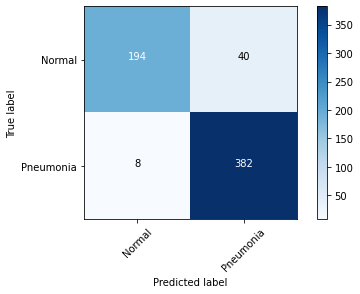

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['Normal', 'Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)
abc='CM'
plt.savefig(f'/mydrive/{abc}.png',bbox_inches="tight",dpi=520)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       234
           1       0.91      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.92       624
weighted avg       0.93      0.92      0.92       624



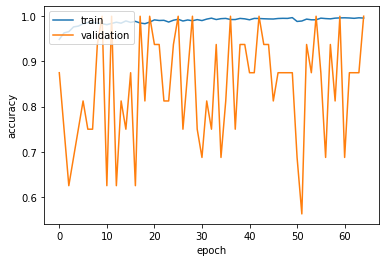

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc='upper left')
plt.show()

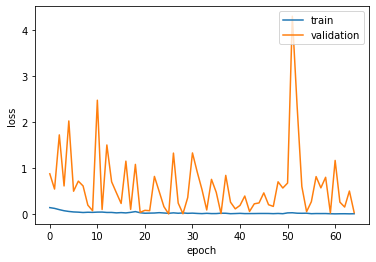

In [ ]:
abc='Loss vs Epoch Graph_350'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc='upper right')
plt.savefig(f'/mydrive{abc}.png',bbox_inches="tight",dpi=520)
plt.show()

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


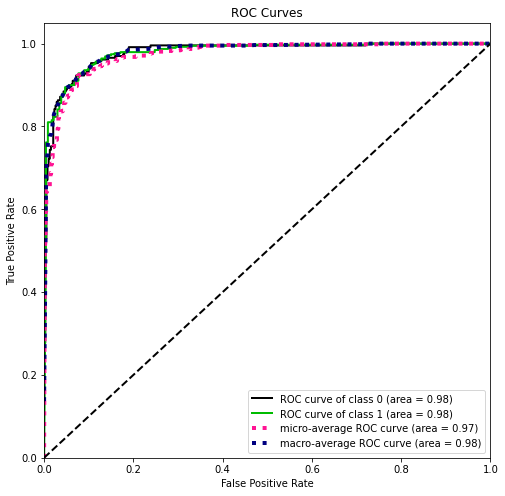

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_roc(
    y_true,
    predictions,
    figsize=(8,8))
abc='ROC Curve Normal_250'
#plt.savefig("/content/drive/MyDrive/Test/"+data[i],bbox_inches='tight', pad_inches=0)

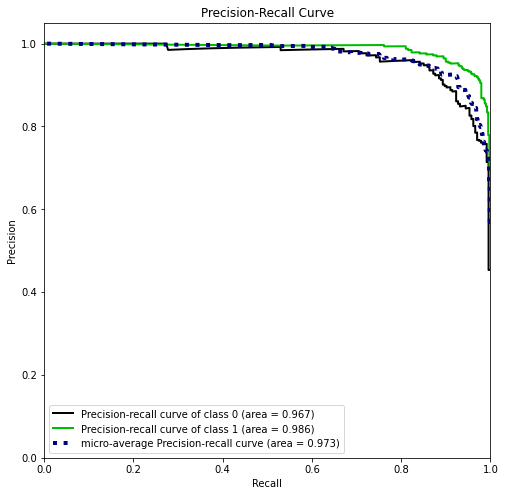

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_precision_recall(
    y_true,
    predictions,
    figsize=(8,8))
abc='AOC Curve Normal_250'
#plt.savefig("/content/drive/MyDrive/Test/"+data[i],bbox_inches='tight', pad_inches=0)